In [2]:
import os
from glob import glob
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from utils.plotting import plot_trajectory
from utils.processing import (
    normalize_angles_2pi,
    open_file,
    cut_jumps
    )


import seaborn as sns
from scipy import stats
#from scipy.ndimage import gaussian_filter1d
# from utils.processing import (
#     normalize_angles_2pi,
#     open_file,
#     cut_jumps,
#     save_preprocessed_data,
#     open_preprocessed_data,
#     )

#####  parameters to change

In [3]:
wall_perc = 0.1

In [4]:
DATA_DIR = 'dataset'
PREPROC_DATA_DIR = 'downsamp_preprocessed_dataset'

# 1. open files
dataset_names = sorted(glob(os.path.join(DATA_DIR, '*.txt')))
datasets = {}
for nam in dataset_names:
    k = Path(nam).stem
    v = open_file(nam, show=False)
    datasets[k] = v

# 2. cut_jumps
tr11 = datasets['Trace_1.1']  # TODO: params to config
tr12 = datasets['Trace_1.2']  
tr2 = datasets['Trace_2']
tr5 = datasets['Trace_5']

tr4 = cut_jumps(datasets['Trace_4'], xmax=40.4, xmin=-38.1, ymax=28.3, ymin=-47.6,show=False)
tr3 = cut_jumps(datasets['Trace_3'], xmax=46.8, xmin=-48, ymax=46, ymin=-47,show=False)
tr6 = cut_jumps(datasets['Trace_6'], xmax=45, xmin=-45, ymax=45, ymin=-42.2,show=False)
tr7 = cut_jumps(datasets['Trace_7'], xmax=35, xmin=-38.7, ymax=40, ymin=-32,show=False)
tr91 = cut_jumps(datasets['Trace_9.1'], xmax=42.5, xmin=-43.7, ymax=42.5, ymin=-42.7,show=False)
tr92 = cut_jumps(datasets['Trace_9.2'], xmax=36.3, xmin=-46.5, ymax=45.4, ymin=-47.3,show=False)

dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

dfs_dict = {}
for k, val in zip(dfs_names, dfs):
    dfs_dict[k] = val

# 3. rescale x and y coords to fit area size 
# может добавить функцию rescale_coord в processing.py? TODO
def rescale_coord(data, new_min, new_max):
    min_old_x, max_old_x = np.min(data), np.max(data)
    data_rescaled = ((data - min_old_x) / (max_old_x - min_old_x)) * (new_max - new_min) + new_min
    return data_rescaled

AREA_SIZE = [-40, 40]
rescaled_dfs_dict = {}
for k, df in dfs_dict.items():
    df = df.dropna()
    rescaled_x = rescale_coord(df['x'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    rescaled_y = rescale_coord(df['y'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    df.loc[:, 'x'] = rescaled_x
    df.loc[:, 'y'] = rescaled_y

    rescaled_dfs_dict[k] = df

# 4. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
def divide_traj_by_nans(df, k, dt_threshold, traj_drop_threshold=5):
    # 1. Drop Nans
    df = df.dropna()
    # 2. Find if any time jumps
    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.
    div_idx = np.where(dt_times > dt_threshold)[0]
    div_idx = np.asarray(div_idx)

    # Divide by time jumps
    if len(div_idx) > 0:
        div_idx = np.concatenate([np.array([0]),
                                  div_idx,
                                  np.array([len(df)])])
        sub_trajectories = []
        start_i = div_idx[0]
        for end_i in div_idx[1:]:
            if end_i - start_i > traj_drop_threshold:
                sub_df = df[start_i:end_i]
                sub_trajectories.append(sub_df)
            start_i = end_i + 1

        return k, sub_trajectories
    else:
        return k, [df]
    
DROP_THRESHOLD = 5
dt_thresholds = {'tr11': 0.035, 'tr12': 0.035, 'tr2': 0.035, 'tr3': 0.135,  # TODO: to configs
                 'tr4': 0.035,  'tr5': 0.035, 'tr6': 0.035, 'tr7': 0.035,
                 'tr91': 0.035, 'tr92': 0.035}

subtraj_dfs_dict = {}
for k, df in rescaled_dfs_dict.items():
    k, df_subtraj= divide_traj_by_nans(df, k, dt_threshold=dt_thresholds[k],
                                       traj_drop_threshold=DROP_THRESHOLD)
    subtraj_dfs_dict[k] = df_subtraj  # list of dfs


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1635007879.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'x'] = rescaled_x
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1635007879.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'y'] = rescaled_y
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1635007879.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

NEW_DT - 1/ new sampling rate 



In [5]:
# 5. resample to required dt


# 6. add angles, delta_angles, step len, 

def add_step_length(df):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dx[0], dy[0] = 0., 0.,
    step_lens = (dx**2 + dy**2)**0.5
    df['step_length'] = step_lens
    return df


dfs_dict_with_angles = {}
for k, df in subtraj_dfs_dict.items():
    subtraj_list = []
    for sub_traj_df in df:
        df_step = add_step_length(sub_traj_df)
        subtraj_list.append(df_step)
    dfs_dict_with_angles[k] = subtraj_list

# 7. sort by areas of open field
#долго выполняется если рисовать все графики


def sort_walls_area(tr, border_tr, wall_percent=0.1): 
    ylen = border_tr['ymax'] - border_tr['ymin'] 
    xlen = border_tr['xmax'] - border_tr['xmin'] 
    xl = border_tr['xmin'] + xlen * wall_percent
    xr = border_tr['xmax'] - xlen * wall_percent
    yd = border_tr['ymin'] + ylen * wall_percent
    yu = border_tr['ymax'] - ylen * wall_percent

    tr['near_wall'] = 0.
    for i in range(len(tr)):     
        if tr['x'].iloc[i] < xl:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 40
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 30
            else:
                tr['near_wall'].iloc[i] = 4
        elif tr['x'].iloc[i] > xr:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 10
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 20
            else:
                tr['near_wall'].iloc[i] = 2
        elif tr['y'].iloc[i] > yu:
            tr['near_wall'].iloc[i] = 1
        elif tr['y'].iloc[i] < yd:
            tr['near_wall'].iloc[i] = 3
    return tr

def plot_wall_sorted_samples(df, plot_title):
    all_areas = [40, 30, 20, 10, 4, 3, 2, 1, 0]
    for a in all_areas:
        x = df.loc[df['near_wall'] == a]['x']
        y = df.loc[df['near_wall'] == a]['y']
        plt.scatter(x, y, s=1.5, label=str(a))
    plt.gca().set_aspect('equal')
    plt.title(plot_title)
    plt.legend(loc='center')
    plt.show()


dfs_with_walls = {}
bord40 =  {'xmin': -40,'xmax': 40,'ymin': -40,'ymax': 40}   

for k, df in dfs_dict_with_angles.items():
    subtraj_list = []
    for sub_df in df:
        sub_df = sort_walls_area(sub_df, bord40, wall_perc)
        #plot_wall_sorted_samples(sub_df, k)
        subtraj_list.append(sub_df)
    dfs_with_walls[k] = subtraj_list







In [8]:
#checked that sampling rate stability in subtrajectories
for k, df in dfs_with_walls.items():
    print(k)
    for ldf in df:
        s_r = (ldf['time'].max() - ldf['time'].min())/ len(ldf)
        print(s_r)

tr11
0.03336604017653325
tr12
0.03336518498802236
0.03336519800681878
0.03304854368932035
0.033362012290981846
tr2
0.03336603694213928
tr3
0.13117241379310346
0.11866666666666642
0.13021951219512193
0.12558823529411794
0.12136363636363709
0.12994736842105306
0.13068749999999993
0.12642105263157974
0.12903333333333364
0.12714285714285656
0.1304318181818183
0.11674999999999969
0.12851851851851848
0.11675000000000324
0.11866666666666485
0.1303720930232557
0.1302857142857138
0.11866666666666485
0.1255882352941171
0.1304888888888892
0.11442857142856967
0.1314776119402989
0.12942424242424116
0.13043181818181762
0.1297777777777785
0.12769565217391357
0.13175641025641008
0.11674999999999613
0.1268000000000029
0.13123333333333373
0.1302857142857138
0.132182692307693
0.12233333333333007
0.13056521739130372
0.13273076923076946
0.131349206349206
0.12564705882352747
0.11674999999999613
0.12679999999999722
0.13238211382113835
0.12983783783783712
0.12679999999999722
0.13043181818181893
0.132496350364

In [10]:
# 7.5 differentiate movements and stops, check percent of movement

#add sum of steps for the last 0.5 seconds to each row (if applicable)

dfs_step_sum = {}

#window_size = round(0.5/0.034)

for k, df in dfs_with_walls.items():
    sub_list = []
    for ldf in df:
        ldf = ldf.iloc[1:]
        #first row of ldf does not have step length
        s_r = (ldf['time'].max() - ldf['time'].min())/ len(ldf)
        window_size = round(0.5/s_r)
        if len(ldf) >= window_size:
            ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
            ldf['step_sum_0.5']=ldf['step_sum_0.5'].fillna(-100)
            sub_list.append(ldf)
        dfs_step_sum[k] = sub_list
        
#merge dfs in dictionary

merg_resampled_dfs_dict = {}

for k, df in dfs_step_sum.items():
    df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_resampled_dfs_dict[k] = pd.concat(df)
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1996961697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1996961697.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5']=ldf['step_sum_0.5'].fillna(-100)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1996961697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1996961697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1996961697.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5']=ldf['step_sum_0.5'].fillna(-100)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1996961697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1996961697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1996961697.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5']=ldf['step_sum_0.5'].fillna(-100)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16572\1996961697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [11]:
def movementOrNot(step_sum, max_step_of_stop):
    if step_sum == -100:
        out = 'NotDefined'
    elif step_sum > max_step_of_stop:
        out = 'Move'
    elif step_sum <= max_step_of_stop:
        out = 'Stop'
    else:
        out = 'error'
    return out

def addMovementColumn(dict_df, threshold):
    new_dict = {}
    for k, df in dict_df.items():
        func = np.vectorize(movementOrNot)
        df["movement"] = func(df['step_sum_0.5'], threshold)
        new_dict[k] = df
    return new_dict
    

In [12]:
def plot_movement_thres(merg_resampled_dfs_dict, threshold_list, list_of_tr):
    double_dict_threshold_mice = {}
    for threshold in threshold_list:
        dfs_stop_local = addMovementColumn(merg_resampled_dfs_dict, threshold)
        dict_mice = {}
        for tr in list_of_tr:
            df = dfs_stop_local[tr]
            dict_mice[tr] = len(df.loc[df['movement']=='Move'])/len(df)
        double_dict_threshold_mice[threshold] = dict_mice
    #сделала 2 цикла, т к если бы я в первом цикле взяла бы более удобный для графиков порядок, вышло бы, что я несколько 
    #раз вычисляю таблицу для каждого порога. еще можно отдельно посчитать эти таблицы
    mice_mov_perc_list_wrt_thr = {}
    for tr in list_of_tr:
        mouse_list = []
        for threshold in threshold_list:
            mouse_list.append(double_dict_threshold_mice[threshold][tr])
        mice_mov_perc_list_wrt_thr[tr] = mouse_list
    plt.figure()
    for tr, mv_perc_mouse in mice_mov_perc_list_wrt_thr.items():
        plt.plot(threshold_list, mv_perc_mouse, label=tr)
    list_with_tr_names = ', '.join(list_of_tr)
    plt.xlabel("Movement threshold")
    plt.ylabel("Movement fraction (from 0 to 1)")
    plt.title('Fraction of movement in mice: ' +  list_with_tr_names)
    plt.legend()
    plt.show()

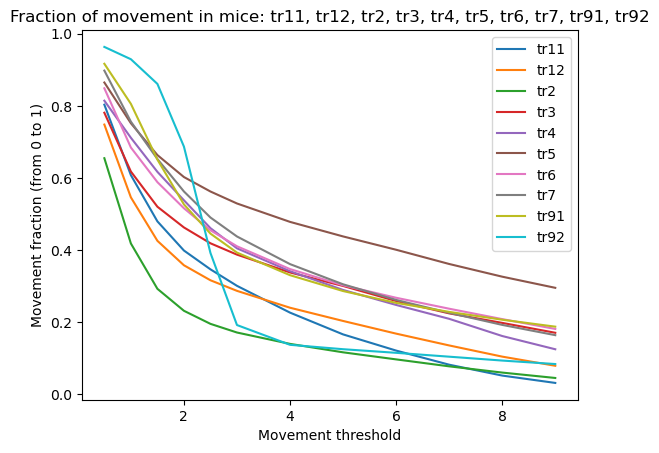

In [15]:
list_plot = [0.5,1,1.5,2,2.5] + list(range(3,10))
all_mice_names = list(merg_resampled_dfs_dict.keys())
plot_movement_thres(merg_resampled_dfs_dict, list_plot, all_mice_names)

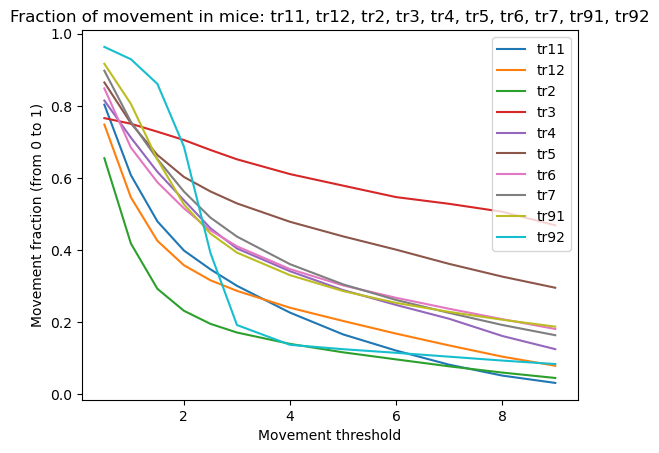

In [91]:
list_plot = [0.5,1,1.5,2,2.5] + list(range(3,10))
all_mice_names = list(merg_resampled_dfs_dict.keys())
plot_movement_thres(merg_resampled_dfs_dict, list_plot, all_mice_names)

Text(0.5, 1.0, 'tr92, truncated view')

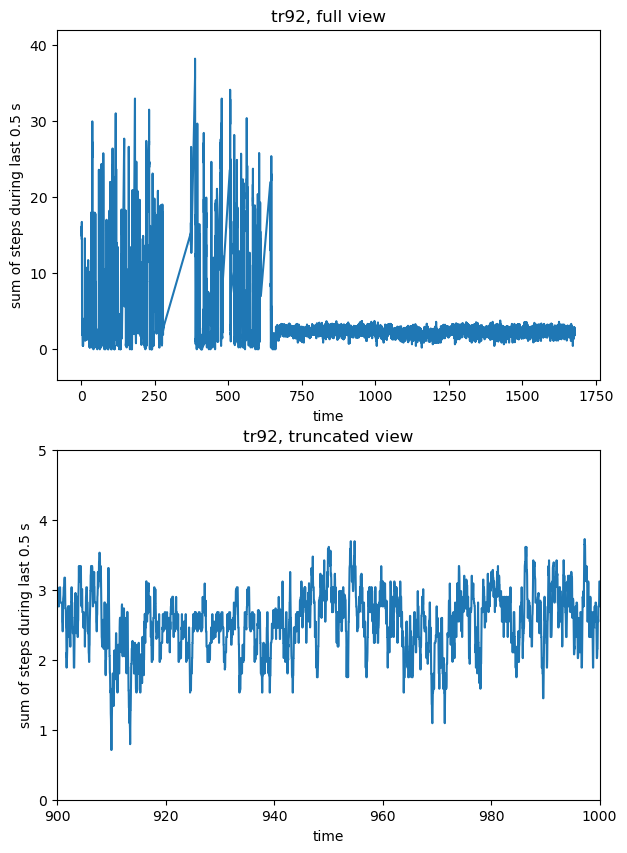

In [124]:
fig, axes = plt.subplots(2, 1,figsize=(7, 10))
df92 = merg_resampled_dfs_dict['tr92'].loc[merg_resampled_dfs_dict['tr92']['step_sum_0.5']>-1]
axes[0].plot(df92['time'], df92['step_sum_0.5'])
axes[0].set(xlabel='time', ylabel='sum of steps during last 0.5 s')
axes[0].set_ylim([-4, 42])
axes[0].set_title('tr92, full view')
axes[1].plot(df92['time'], df92['step_sum_0.5'])
axes[1].set(xlabel='time', ylabel='sum of steps during last 0.5 s')
axes[1].set_xlim([900, 1000])
axes[1].set_ylim([0, 5])
axes[1].set_title('tr92, truncated view')
#, fontsize=10

In [128]:
# # Save distributions

dfs_stop_save = addMovementColumn(merg_resampled_dfs_dict, 2.5)

with open('preprocessed_dfs_subtraj_for_marks.pkl', 'wb') as fp:    
    pickle.dump(dfs_stop_save, fp)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(dfs_stop['tr11'][0].loc[800:1100])


In [126]:
# def plot_movement_thres_aver(merg_resampled_dfs_dict, threshold, list_of_tr):
#     mv = []
#     mv_wall = []
#     mv_cent = []
#     mv_corn = []
#     st = []
#     merg_resampled_dfs_dict = addMovementColumn(merg_resampled_dfs_dict, threshold)
#     for tr in list_of_tr:
#         df = merg_resampled_dfs_dict[tr]
#         wall_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=1)&(df['near_wall']<=4)])\
#         /len(df.loc[(df['near_wall']>=1)&(df['near_wall']<=4)])
#         corn_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=10)&(df['near_wall']<=40)])\
#         /len(df.loc[(df['near_wall']>=10)&(df['near_wall']<=40)])
#         cent_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']==0)])\
#         /len(df.loc[(df['near_wall']==0)])
#         mv.append(len(df.loc[df['movement']=='Move'])/len(df))
#         mv_wall.append(wall_m)
#         mv_cent.append(cent_m)
#         mv_corn.append(corn_m)
# #     print('move, mean',np.mean(mv))
# #     print('stop, mean',np.mean(st))
# #     print('mv_wall',mv_wall)
# #     print('move near wall, mean',np.mean(mv_wall))
# #     print('move near center, mean',np.mean(mv_cent))
# #     print('move near corner, mean',np.mean(mv_corn))
#     plt.figure()
#     plt.plot(mv, label='mean in whole area')
#     plt.plot(mv_wall, label='mean in wall area')
#     plt.plot(mv_cent, label='mean in cent area')
#     plt.plot(mv_corn, label='mean in corn area')
#     plt.legend()
#     list_with_tr_names = ', '.join(list_of_tr)
#     plt.title('Mean perecent of movement in mice: ' +  list_with_tr_names)
#     plt.show()

In [9]:
mv = []
mv_wall = []
mv_cent = []
mv_corn = []
st = []
#new 20/02/2024
# draft
# merge dfs of each mouse
#dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
#the first row from each df is deleted because it has angle 0 and delta angle 0
#ну он хоть как-то соотвествует видео)))

for k,df in merg_resampled_dfs_dict.items():
    print(k,'perc of move', len(df.loc[df['movement']=='Move'])/len(df))
    mv.append(len(df.loc[df['movement']=='Move'])/len(df))
    
    wall_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=1)&(df['near_wall']<=4)])\
    /len(df.loc[(df['near_wall']>=1)&(df['near_wall']<=4)])
    corn_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=10)&(df['near_wall']<=40)])\
    /len(df.loc[(df['near_wall']>=10)&(df['near_wall']<=40)])
    cent_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']==0)])\
    /len(df.loc[(df['near_wall']==0)])
    mv_wall.append(wall_m)
    mv_cent.append(cent_m)
    mv_corn.append(corn_m)
    
    mv.append(len(df.loc[df['movement']=='Move'])/len(df))
    print(k,'perc of stop', len(df.loc[df['movement']=='Stop'])/len(df))
    st.append(len(df.loc[df['movement']=='Stop'])/len(df))
print('move, mean',np.mean(mv))
print('stop, mean',np.mean(st))
print('mv_wall',mv_wall)
print('move near wall, mean',np.mean(mv_wall))
print('move near center, mean',np.mean(mv_cent))
print('move near corner, mean',np.mean(mv_corn))

for k in merg_resampled_dfs_dict:
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].loc[merg_resampled_dfs_dict[k]['movement']=='Move']

    
    

tr11 perc of move 0.22626792984058136
tr11 perc of stop 0.7734847620134688
tr12 perc of move 0.23986898232784887
tr12 perc of stop 0.7591407678244972
tr2 perc of move 0.1395709040844424
tr2 perc of stop 0.8601805109377391
tr3 perc of move 0.6105879891190625
tr3 perc of stop 0.15547185603682778
tr4 perc of move 0.34116006044403113
tr4 perc of stop 0.5213297686853423
tr5 perc of move 0.4782657955360852
tr5 perc of stop 0.45692813172702895
tr6 perc of move 0.3469222231708358
tr6 perc of stop 0.6225561342098523
tr7 perc of move 0.36063839167621903
tr7 perc of stop 0.6152896569967375
tr91 perc of move 0.330155741242007
tr91 perc of stop 0.656584676944804
tr92 perc of move 0.13702251800528764
tr92 perc of stop 0.8534962166104476
move, mean 0.3210460535446401
stop, mean 0.6274462481986746
mv_wall [0.28526698823728525, 0.289636809918043, 0.18286682261837542, 0.5872235872235873, 0.5279337865799586, 0.5778907030989671, 0.3998870641381582, 0.4019357103455193, 0.33492608151877623, 0.06835142469470

In [27]:
# draft
# merge dfs of each mouse
#dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
#the first row from each df is deleted because it has angle 0 and delta angle 0
#ну он хоть как-то соотвествует видео)))
merg_resampled_dfs_dict = {}
mv = []
mv_wall = []
mv_cent = []
mv_corn = []
st = []
for k, df in dfs_stop.items():
    df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_resampled_dfs_dict[k] = pd.concat(df)
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)
for k,df in merg_resampled_dfs_dict.items():
    print(k,'perc of move', len(df.loc[df['movement']=='Move'])/len(df))
    mv.append(len(df.loc[df['movement']=='Move'])/len(df))
    
    wall_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=1)&(df['near_wall']<=4)])\
    /len(df.loc[(df['near_wall']>=1)&(df['near_wall']<=4)])
    corn_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=10)&(df['near_wall']<=40)])\
    /len(df.loc[(df['near_wall']>=10)&(df['near_wall']<=40)])
    cent_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']==0)])\
    /len(df.loc[(df['near_wall']==0)])
    mv_wall.append(wall_m)
    mv_cent.append(cent_m)
    mv_corn.append(corn_m)
    
    mv.append(len(df.loc[df['movement']=='Move'])/len(df))
    print(k,'perc of stop', len(df.loc[df['movement']=='Stop'])/len(df))
    st.append(len(df.loc[df['movement']=='Stop'])/len(df))
print('move, mean',np.mean(mv))
print('stop, mean',np.mean(st))
print('mv_wall',mv_wall)
print('move near wall, mean',np.mean(mv_wall))
print('move near center, mean',np.mean(mv_cent))
print('move near corner, mean',np.mean(mv_corn))

for k in merg_resampled_dfs_dict:
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].loc[merg_resampled_dfs_dict[k]['movement']=='Move']

    
    

tr11 perc of move 0.6077122094129285
tr11 perc of stop 0.39204048244112166
tr12 perc of move 0.5460085313833029
tr12 perc of stop 0.45300121876904326
tr2 perc of move 0.41811993269083675
tr2 perc of stop 0.5816314823313447
tr3 perc of move 0.750366185394434
tr3 perc of stop 0.015693659761456372
tr4 perc of move 0.7118447053353482
tr4 perc of stop 0.15064512379402534
tr5 perc of move 0.7519166131651498
tr5 perc of stop 0.1832773140979644
tr6 perc of move 0.6840903269871084
tr6 perc of stop 0.2853880303935798
tr7 perc of move 0.7557975487170443
tr7 perc of stop 0.2201304999559122
tr91 perc of move 0.8055195951512298
tr91 perc of stop 0.18122082303558118
tr92 perc of move 0.9293007566779105
tr92 perc of stop 0.061217977937824776
move, mean 0.6960676404915294
stop, mean 0.25242466125178536
mv_wall [0.7201066260472201, 0.6432583101052544, 0.46176494313140276, 0.7381537381537382, 0.7735737511084836, 0.8418027324225258, 0.7092842689755776, 0.7997091419688079, 0.8251290767405317, 0.97139303482